# Transfer Learning Pytorch

In [68]:
import torch
from torchvision import datasets,models,transforms
from torch import optim
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import copy

## load dataset


In [69]:
# transform of data
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    "train" : transforms.Compose([
     transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean , std= std),    
    ]),
    
    "val" : transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean , std= std),
    
    ])}

In [3]:
dataset_address = "./dataset/"
data_types = ["train", "val"]
dataset = {data_type : datasets.ImageFolder(os.path.join(dataset_address , data_type) , data_transforms[data_type])
             for data_type in data_types}
data_loader ={ data_type : DataLoader(dataset[data_type] , shuffle=True , batch_size=8) for data_type in data_types}

num_samples = {x: len(dataset[x]) for x in ['train', 'val']}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


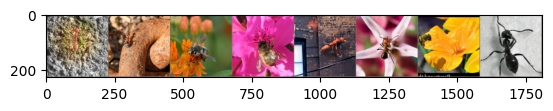

In [70]:
example_data, example_classes = next(iter(data_loader['train']))
example_grid = torchvision.utils.make_grid(example_data)
numpy_example_grid = example_grid.numpy()
numpy_example_grid = numpy_example_grid.transpose((1,2,0))
plt.imshow(numpy_example_grid*std + mean)
plt.savefig("example data.png")
plt.show()

# Create model

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [21]:
def evaluate_model(model ,data_loader,criterion , optimizer):
    model.eval()
    sum_loss = 0.0
    sum_correct = 0.0
    for input , label in data_loader["val"]:
        input = input.to(device)
        label = label.to(device)
        with torch.no_grad():
            optimizer.zero_grad()
            predicted = model(input)
            loss = criterion(predicted , label)
            sum_loss+= loss.item() * input.shape[0]
            sum_correct += torch.sum(torch.argmax(predicted , 1)== label)
    val_accuracy = sum_correct / num_samples["val"]
    val_loss = sum_loss / num_samples["val"]
    return val_accuracy , val_loss

In [22]:
def Train_model(model ,data_loader,criterion , optimizer , epochs=5 , evaluate = False ):
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    for epoch in range(epochs):
        model.train()
        sum_loss = 0.0
        sum_correct = 0.0
        for input , label in data_loader["train"]:
            input = input.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            predicted = model(input)

            loss = criterion(predicted , label)

            loss.backward()

            optimizer.step()

            sum_loss+= loss.item() * input.shape[0]
            sum_correct += torch.sum(torch.argmax(predicted , 1)== label)
        train_accuracy = sum_correct / num_samples["train"]
        train_loss = sum_loss / num_samples["train"]

        if evaluate:
            val_accuracy , val_loss = evaluate_model(model , data_loader , criterion , optimizer)
            print(f"Epoch {epoch+1} / {epochs} - train loss = {train_loss:.4f} - train accuracy = {train_accuracy:.4f} - validation loss = {val_loss:.4f} - valiation accuracy = {val_accuracy:.4f}")
            if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_model = copy.deepcopy(model.state_dict())
        else:
            print(f"Epoch {epoch+1} / {epochs} - train loss = {train_loss:.4f} - train accuracy = {train_accuracy:.4f}")
            if train_accuracy > best_acc:
                best_acc = train_accuracy
                best_model = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model)
    return model

In [23]:
model = models.resnet18(weights='IMAGENET1K_V1')

num_input_features = model.fc.in_features

In [24]:
for parameter in model.parameters():
    parameter.requires_grad = False

fc = nn.Linear(num_input_features , 2)
model.fc = fc
model = model.to(device=device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [25]:
model = Train_model(model ,data_loader,criterion , optimizer , epochs=25 , evaluate = True)

Epoch 1 / 25 - train loss = 0.5973 - train accuracy = 0.6393 - validation loss = 0.3966 - valiation accuracy = 0.8497
Epoch 2 / 25 - train loss = 0.3444 - train accuracy = 0.8811 - validation loss = 0.2853 - valiation accuracy = 0.9216
Epoch 3 / 25 - train loss = 0.2845 - train accuracy = 0.8975 - validation loss = 0.2301 - valiation accuracy = 0.9281
Epoch 4 / 25 - train loss = 0.2808 - train accuracy = 0.8770 - validation loss = 0.2576 - valiation accuracy = 0.8889
Epoch 5 / 25 - train loss = 0.2944 - train accuracy = 0.8811 - validation loss = 0.2221 - valiation accuracy = 0.9281
Epoch 6 / 25 - train loss = 0.2577 - train accuracy = 0.8975 - validation loss = 0.1836 - valiation accuracy = 0.9412
Epoch 7 / 25 - train loss = 0.1690 - train accuracy = 0.9467 - validation loss = 0.1798 - valiation accuracy = 0.9477
Epoch 8 / 25 - train loss = 0.1955 - train accuracy = 0.9303 - validation loss = 0.1827 - valiation accuracy = 0.9412
Epoch 9 / 25 - train loss = 0.1765 - train accuracy = 0.

In [10]:
for parameter in model.parameters():
    parameter.requires_grad = True


model = Train_model(model ,data_loader,criterion , optimizer , epochs=10 , evaluate = True)

Epoch 1 / 10 - train loss = 1.6179 - train accuracy = 0.6148 - validation loss = 0.8392 - valiation accuracy = 0.5556
Epoch 2 / 10 - train loss = 0.7566 - train accuracy = 0.6107 - validation loss = 0.6236 - valiation accuracy = 0.6536
Epoch 3 / 10 - train loss = 0.6229 - train accuracy = 0.7131 - validation loss = 0.6431 - valiation accuracy = 0.6340
Epoch 4 / 10 - train loss = 0.6359 - train accuracy = 0.6639 - validation loss = 0.5738 - valiation accuracy = 0.7386
Epoch 5 / 10 - train loss = 0.5859 - train accuracy = 0.7008 - validation loss = 0.5878 - valiation accuracy = 0.6928
Epoch 6 / 10 - train loss = 0.4820 - train accuracy = 0.7623 - validation loss = 0.4876 - valiation accuracy = 0.7255
Epoch 7 / 10 - train loss = 0.4686 - train accuracy = 0.8033 - validation loss = 0.8964 - valiation accuracy = 0.6536
Epoch 8 / 10 - train loss = 0.5338 - train accuracy = 0.7910 - validation loss = 0.6165 - valiation accuracy = 0.6732
Epoch 9 / 10 - train loss = 0.4243 - train accuracy = 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


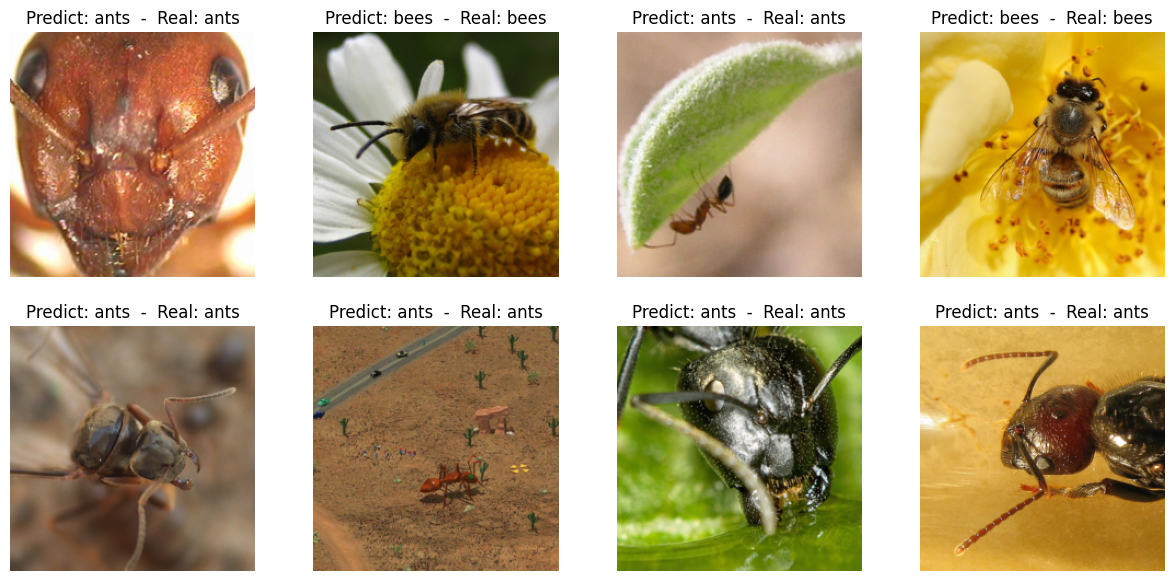

In [80]:
def predict_model(model , data_loader):
    with torch.no_grad():
        input , label = next(iter(data_loader["val"]))
        input= input.to(device)
        predicted = torch.argmax(model(input),1)
        fig = plt.figure(figsize=(15,7))
        for i in range(len(input)):
            image = input[i].cpu().numpy()
            image = image.transpose((1,2,0))
            ax = plt.subplot(2,4,i+1)
            ax.axis('off')
            title = "Predict: " + dataset["train"].classes[predicted[i].cpu().item()]+"  -  Real: " +dataset["train"].classes[label[i].item()]
            ax.set_title(title)
            plt.imshow((image* std + mean))
        plt.savefig("output.png")
        plt.show()
            
predict_model(model , data_loader)  